Question 2:


Average accuracy from Cross-validation: 0.78


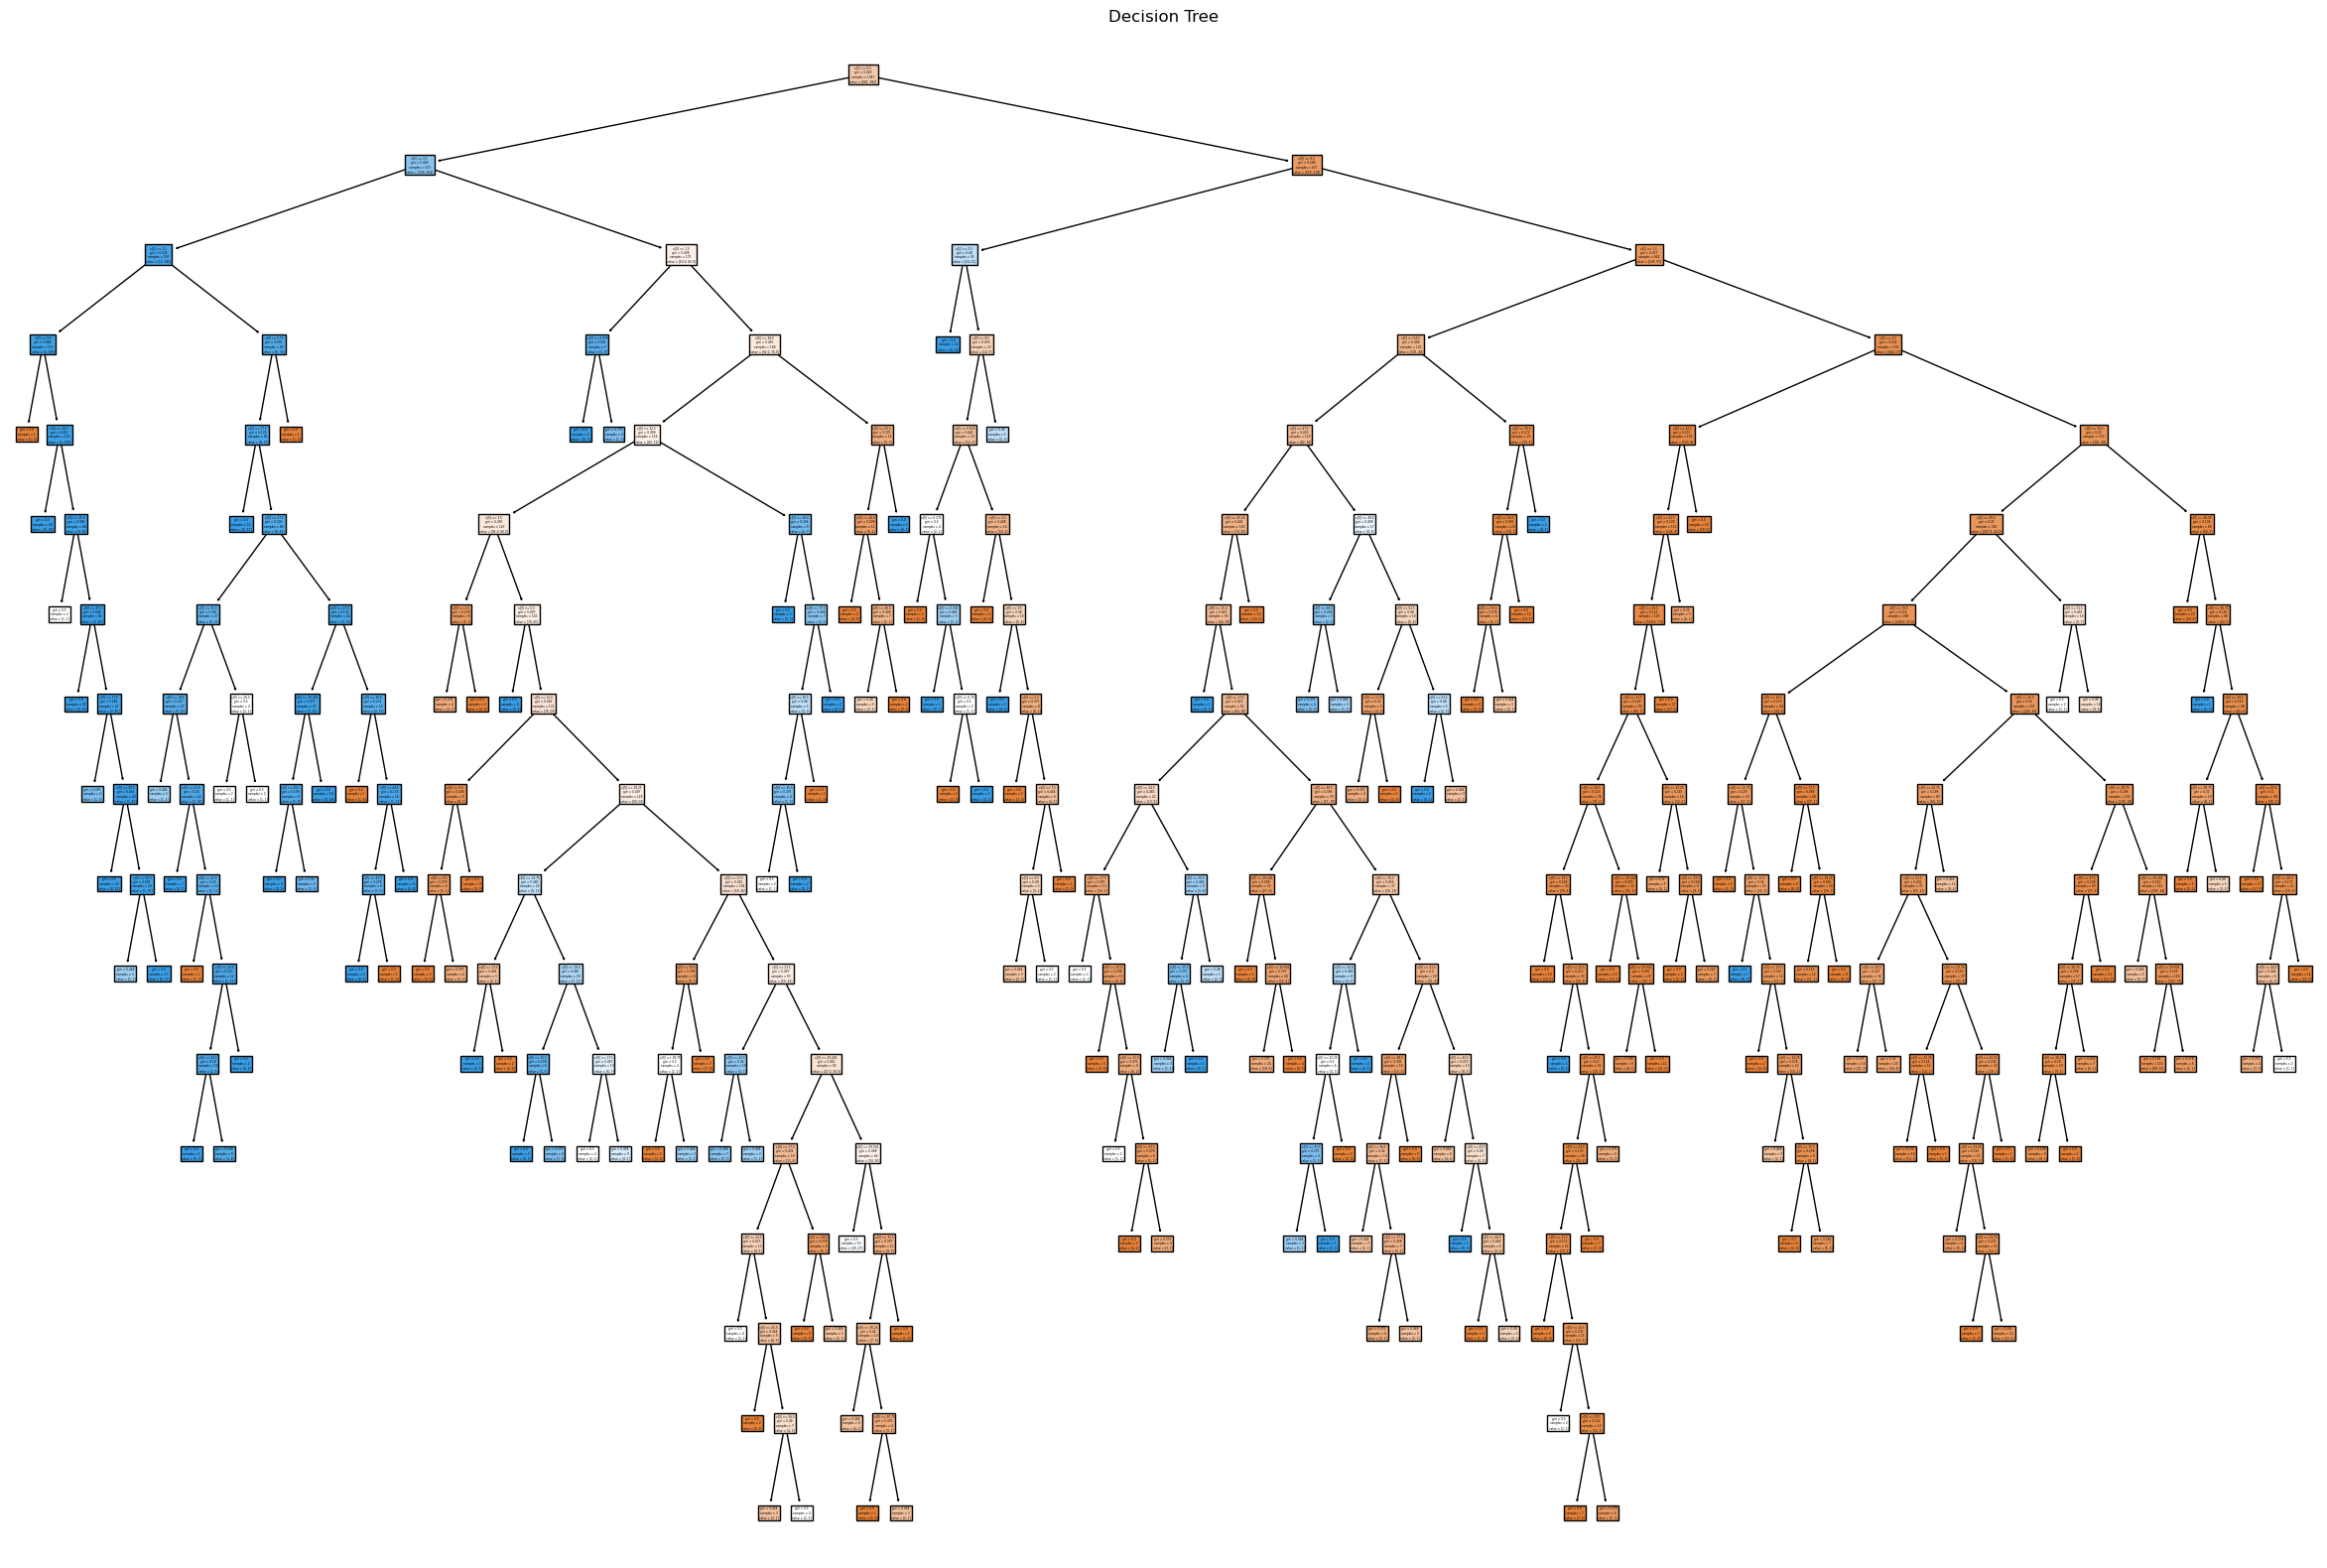

Before Pruning - Accuracy: 0.74
Before Pruning - Misclassification Error Rate:0.26
Before Pruning - Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.88      0.79       144
           1       0.80      0.57      0.66       118

    accuracy                           0.74       262
   macro avg       0.76      0.72      0.73       262
weighted avg       0.75      0.74      0.73       262

Before Pruning - Confusion Matrix:

[[127  17]
 [ 51  67]]


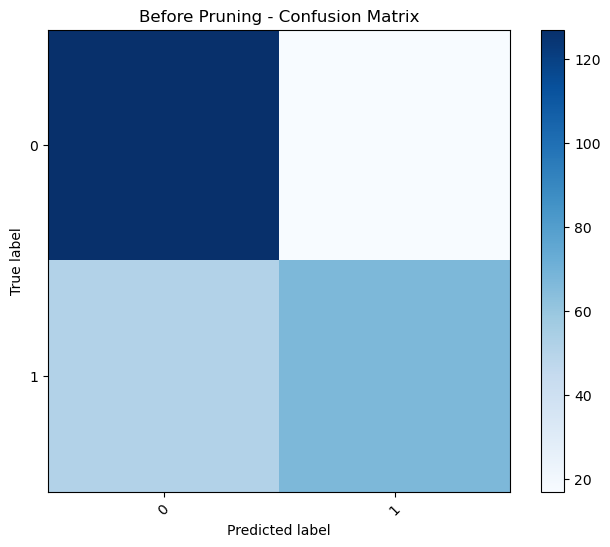

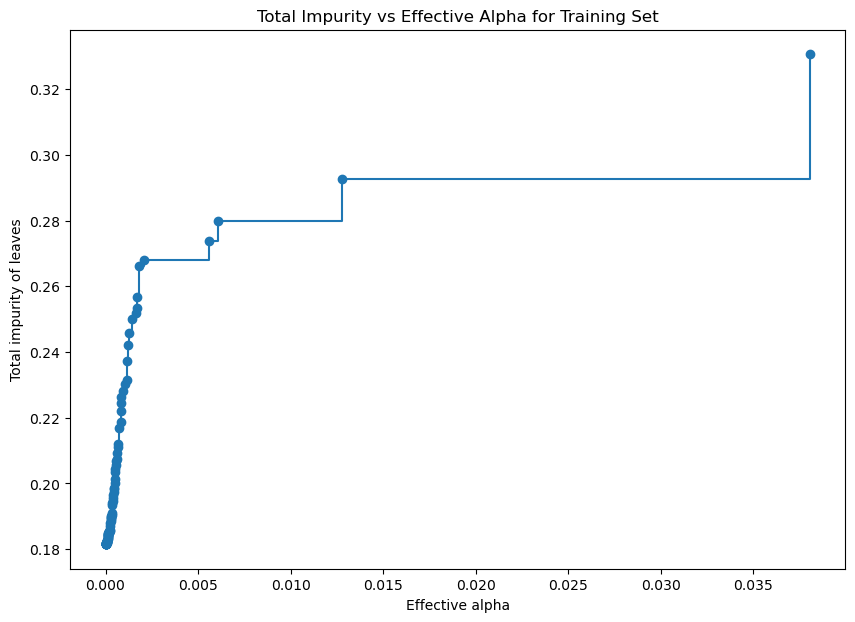

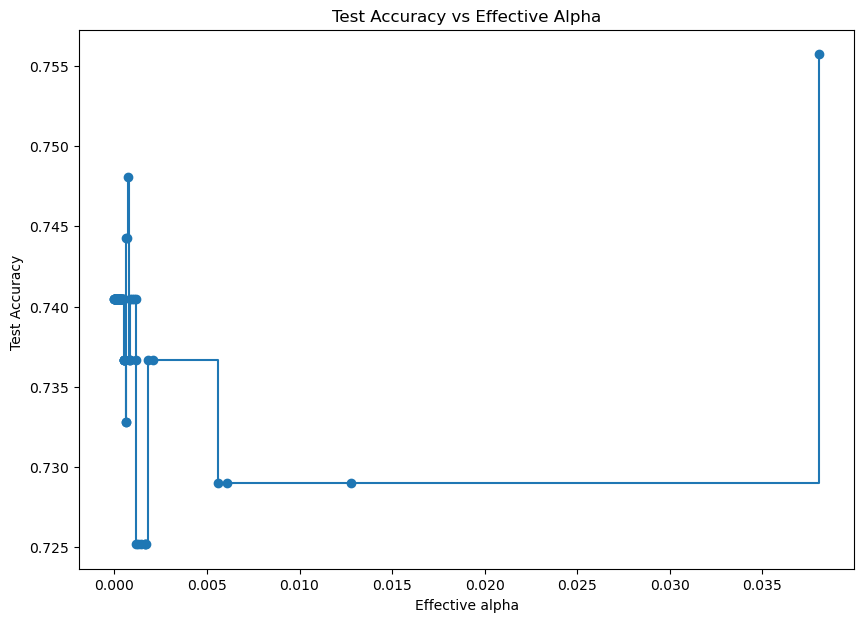

Best ccp_alpha: 0.03805531278310645, with accuracy: 0.76
After Pruning - Accuracy: 0.76
After Pruning - Misclassification Error Rate:0.24
After Pruning - Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79       144
           1       0.78      0.64      0.70       118

    accuracy                           0.76       262
   macro avg       0.76      0.74      0.75       262
weighted avg       0.76      0.76      0.75       262

After Pruning - Confusion Matrix:

[[123  21]
 [ 43  75]]


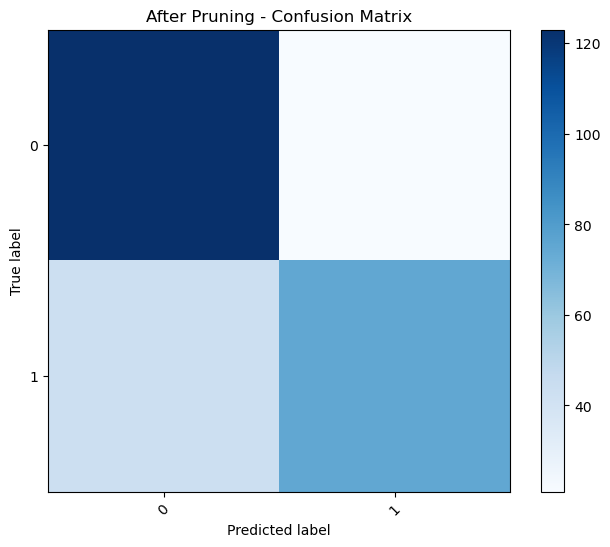

Logistic Regression - Accuracy: 0.77
Misclassification Error Rate: 0.23
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.89      0.81       144
           1       0.82      0.64      0.72       118

    accuracy                           0.77       262
   macro avg       0.79      0.76      0.77       262
weighted avg       0.78      0.77      0.77       262

Confusion Matrix:

[[128  16]
 [ 43  75]]


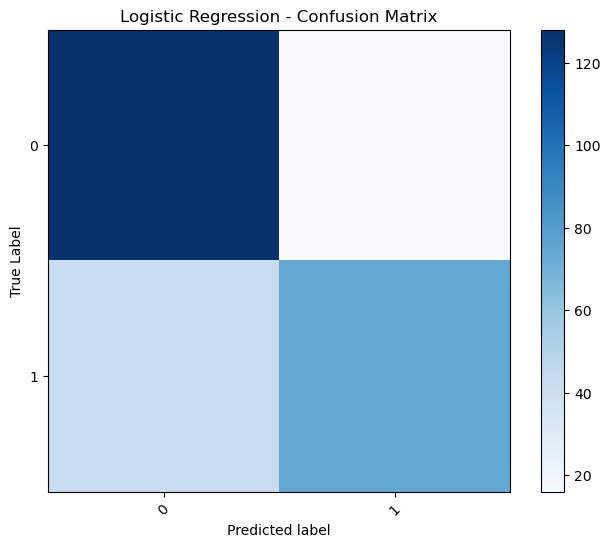

In [20]:
# to utilize the plot function 
import pandas as pd
# to plot and configure graphs
import matplotlib.pyplot as plt
import numpy as np
# to utilize the OLS
import statsmodels.api as st 

from sklearn.feature_selection import RFE

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error as mse

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_score, f1_score, recall_score

from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier, plot_tree

# reading data from csv file
titan_df = pd.read_csv('data/titanic3.csv')
# print(titan_df) 

# drop unecesasary columns
titan_df = titan_df.drop(columns=['name','sibsp','parch','ticket','fare', 'cabin', 'embarked','boat','body','home.dest'])

# impute missing values using mean
mean_age = titan_df['age'].mean()
titan_df['age'] = titan_df['age'].fillna(mean_age)

# titan_df.describe()

# transform categorical features to numerical
titan_df['sex'] = titan_df['sex'].map({'female':0, 'male':1})

X = titan_df[['age', 'sex', 'pclass',]]

y=titan_df['survived'].astype(int)


# splitting data
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.2, random_state=42)

# create and fit decision tree classifier
model = DecisionTreeClassifier(random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(model, X_train, y_train,cv=kfold)

print(f"Average accuracy from Cross-validation: {np.mean(cv_scores):.2f}")

model.fit(X_train, y_train)

# prediction on test data 
y_pred = model.predict(X_test)

# visualize the decision tree
plt.figure(figsize=(30,20))
plot_tree(model, filled=True)
plt.title("Decision Tree")
plt.show()

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# calculate misclassification error
misclassification_error = 1-accuracy

print(f"Before Pruning - Accuracy: {accuracy:.2f}")
print(f"Before Pruning - Misclassification Error Rate:{misclassification_error:.2f}")

# detailed report for further analysis
class_report = classification_report(y_test, y_pred)
print("Before Pruning - Classification Report:\n", class_report)

# display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Before Pruning - Confusion Matrix:\n")
print(conf_matrix)

# plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(conf_matrix,interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Before Pruning - Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y), rotation=45)
plt.yticks(tick_marks, np.unique(y))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# visualize total impurity movement with different ccp_alpha
plt.figure(figsize=(10,7))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Total impurity of leaves")
plt.title("Total Impurity vs Effective Alpha for Training Set")
plt.show()

# train series of decision trees with diff values of ccp_alpha
models =[]
for ccp_alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    model.fit(X_train,y_train)
    models.append(model)
    
# find the accuracy for each pruned tree on test set
test_accuracies = [model.score(X_test, y_test) for model in models]

#plot accuracy vs alpha values
plt.figure(figsize=(10,7))
plt.plot(ccp_alphas[:-1], test_accuracies[:-1], marker="o", drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Test Accuracy ")
plt.title("Test Accuracy vs Effective Alpha")
plt.show()

# find best alpha
best_alpha_index = np.argmax(test_accuracies)
best_alpha = ccp_alphas[best_alpha_index]
print(f"Best ccp_alpha: {best_alpha}, with accuracy: {test_accuracies[best_alpha_index]:.2f}")

# create pruned tree from best alpha
p_tree= DecisionTreeClassifier(ccp_alpha=best_alpha)
p_tree.fit(X_train, y_train)

# make predictions using best alpha pruned tree
y_pred = p_tree.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# calculate misclassification error
misclassification_error = 1-accuracy

print(f"After Pruning - Accuracy: {accuracy:.2f}")
print(f"After Pruning - Misclassification Error Rate:{misclassification_error:.2f}")

# detailed report for further analysis
class_report = classification_report(y_test, y_pred)
print("After Pruning - Classification Report:\n", class_report)

# display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("After Pruning - Confusion Matrix:\n")
print(conf_matrix)

# plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(conf_matrix,interpolation='nearest', cmap=plt.cm.Blues)
plt.title('After Pruning - Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y), rotation=45)
plt.yticks(tick_marks, np.unique(y))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# now with the logistic regression model
logistic_model = LogisticRegression(max_iter=1000)

# fit the model on training data
logistic_model.fit(X_train,y_train)

# make predictions on test
y_pred = logistic_model.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# calc misclassification error
misclassification_error = 1-accuracy

print(f"Logistic Regression - Accuracy: {accuracy:.2f}")
print(f"Misclassification Error Rate: {misclassification_error:.2f}")

# detailed report for further analysis
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n")
print(conf_matrix)

plt.figure(figsize=(8,6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Logistic Regression - Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y), rotation=45)
plt.yticks(tick_marks, np.unique(y))
plt.ylabel('True Label')
plt.xlabel('Predicted label')
plt.show()









Question 3:


Accuracy: 0.78
Cross-validation Scores: [0.80152672 0.75572519 0.81679389 0.77099237 0.79389313 0.81679389
 0.83206107 0.82442748 0.73282443 0.74615385]
Mean Accuracy: 0.7891192014092778
Standard Deviation: 0.03355302960055079
Log Loss for each fold: [3.017948660573611, 1.7369351699220184, 1.9397041501708132, 2.768321308914769, 1.6953593837576204, 2.471418013755434, 0.8544206917286382, 1.931629415100982, 2.065743373369805, 2.0431859164411286]
Mean Log Loss: 2.052466608373482
Resubstitution Log Loss: 0.4174247380529536
Optimal number of neighbors: 20


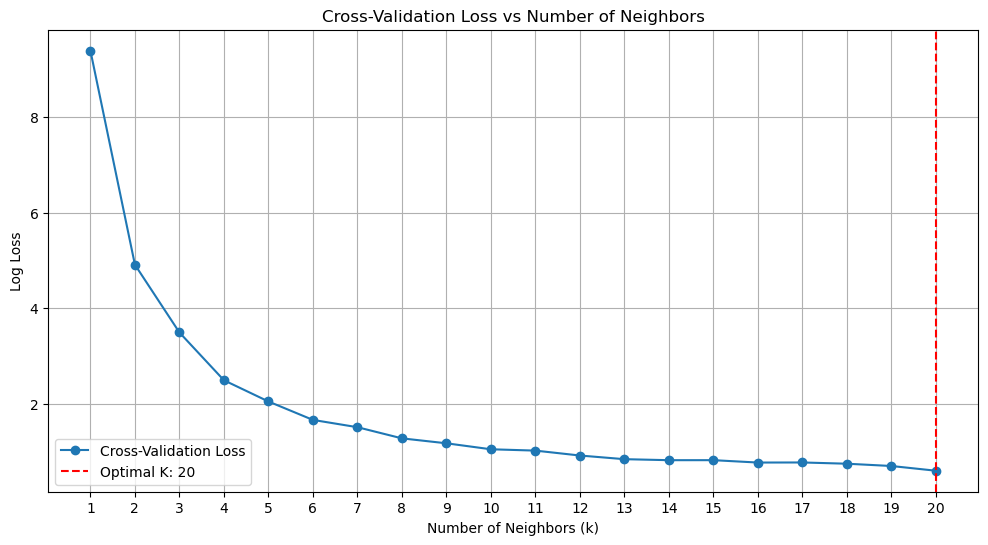

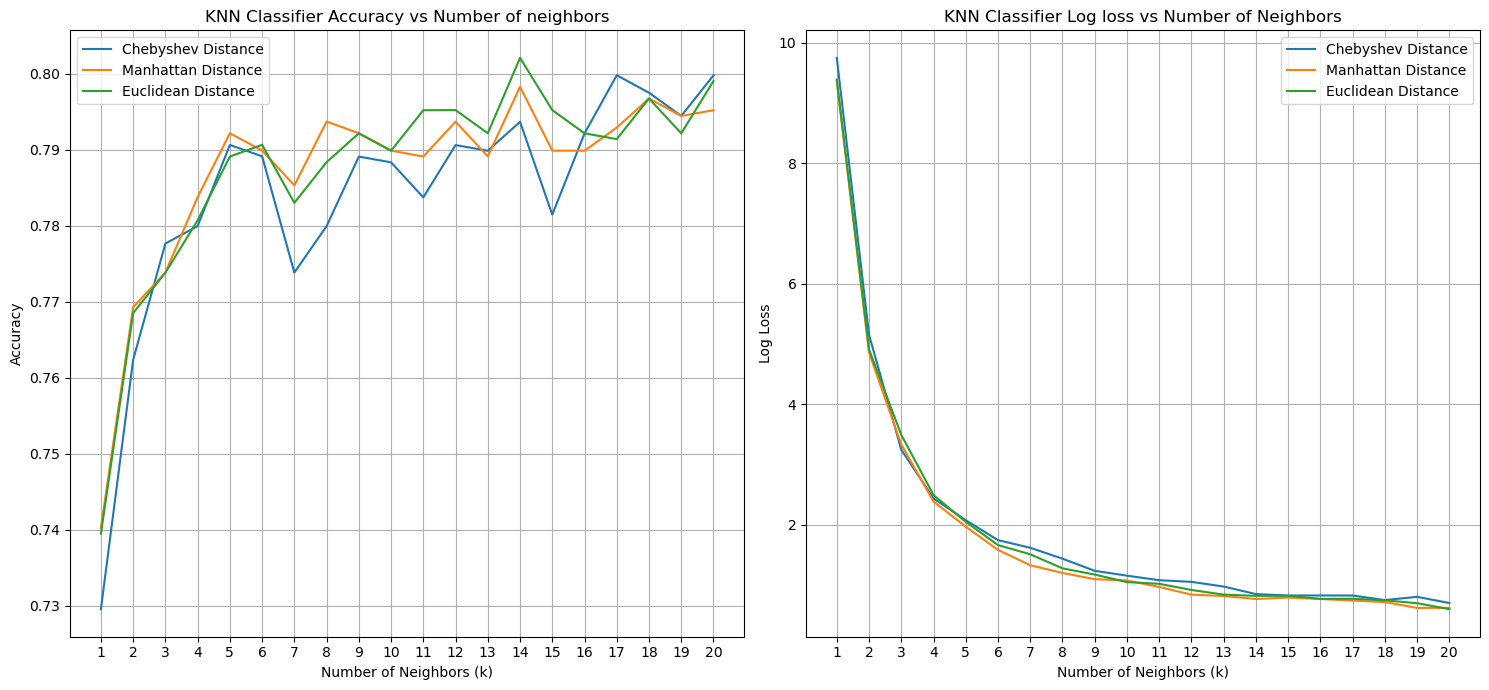


 Optimal k values for each distance metric:
{'chebyshev': 20, 'manhattan': 19, 'euclidean': 20}

 Best KNN Config: k=20, Distance Metric=euclidean
KNN Accuracy: 0.7442748091603053
KNN Log Loss: 0.6122819110884795
Logistic Regression Accuracy: 0.7709923664122137
Logistic Regression Log Loss: 0.4901828801488624

 Comparison of Models:
                 Model  Accuracy  Log Loss
0                  KNN  0.744275  0.612282
1  Logistic Regression  0.770992  0.490183


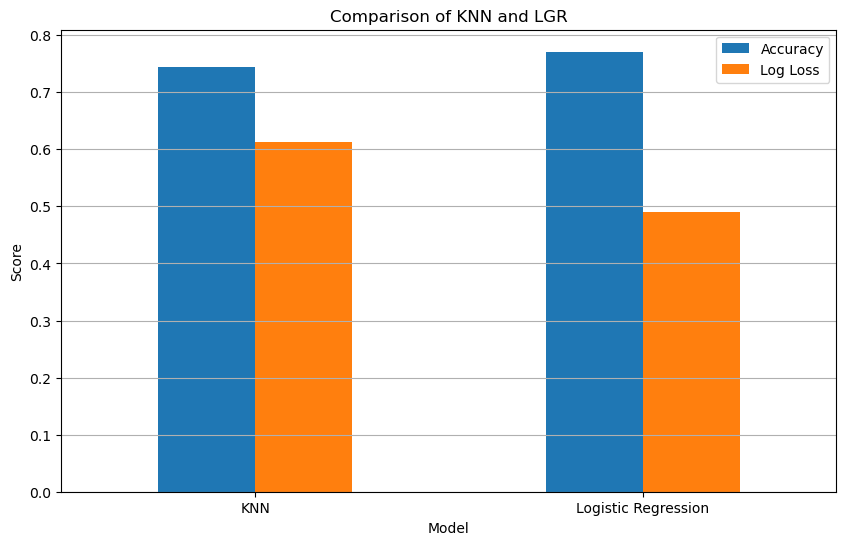

In [192]:
# to utilize the plot function 
import pandas as pd
# to plot and configure graphs
import matplotlib.pyplot as plt
import numpy as np
# to utilize the OLS
import statsmodels.api as st 

from sklearn.feature_selection import RFE

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error as mse

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_score, f1_score, recall_score

from sklearn.metrics import confusion_matrix, log_loss

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

# reading data from csv file
titan_df = pd.read_csv('data/titanic3.csv')
# print(titan_df) 

# drop unnecessary columns
titan_df = titan_df.drop(columns=['name','ticket', 'embarked','boat','body','cabin','home.dest'])

# impute missing values using mean
mean_age = titan_df['age'].median()
titan_df['age'] = titan_df['age'].fillna(mean_age)

mean_fare = titan_df['fare'].mean()
titan_df['fare'] = titan_df['fare'].fillna(mean_fare)


# transform categorical features to numerical
titan_df['sex'] = titan_df['sex'].map({'female':0, 'male':1})

X = titan_df[['age', 'sex', 'pclass','sibsp', 'parch', 'fare']]

y=titan_df['survived'].astype(int)


# apply standard scaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(x_scaled,y, test_size=0.2, random_state=42)


# create and fit decision tree classifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

# KFold cross validation setup
kFold = KFold(n_splits=10, shuffle=True, random_state=42)

# # resubstitution loss
# y_pred_proba_in_sample = model.predict_proba(X_train)
# resubstitution_loss = log_loss(y_train, y_pred_proba_in_sample)

accuracy = model.score(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

# Default model evaluation using cross-validation 
cv_scores = cross_val_score(model, x_scaled, y, cv=kFold, scoring='accuracy')

print(f"Cross-validation Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean()}")
print(f"Standard Deviation: {cv_scores.std()}")
# print(f"Resubstitution Log Loss: {resubstitution_loss:.4f}")

# finding the log loss for each fold (kfold loss)
logLosses = []

for train_index, test_index in kFold.split(x_scaled):
    X_train_f, x_test_f = x_scaled[train_index], x_scaled[test_index]
    y_train_f, y_test_f = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train_f, y_train_f)
    # loss = 1- model.score(X_test_f, y_test_f)
    y_pred_proba = model.predict_proba(x_test_f)
    logLosses.append(log_loss(y_test_f, y_pred_proba))
    

print(f'Log Loss for each fold: {logLosses}')
print(f'Mean Log Loss: {sum(logLosses)/len(logLosses)}')

# fit model on whole dataset to find resubstitution loss
model.fit(x_scaled, y)
y_train_pred_proba=model.predict_proba(x_scaled)

# calculate resubstitution log loss
resubstitution_loss = log_loss(y, y_train_pred_proba)

print(f'Resubstitution Log Loss: {resubstitution_loss}')



# setup grid for n_neighbours and test for neighbours upto 20 from 1
n_neighbors = range(1,21)
mean_accuracies = []
train_scores = []
cv_losses = []
in_sample_losses = []

# quick KFlod Cross -validation
for n in n_neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    f_losses = []

    for train_index, test_index in kFold.split(x_scaled): 
        X_train_fold, X_test_fold = x_scaled[train_index], x_scaled[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_proba_fold = model.predict_proba(X_test_fold)
        
        # log loss for current fold
        f_losses.append(log_loss(y_test_fold, y_pred_proba_fold))
    
    # average log loss across fold for cross-validation loss
    cv_losses.append(np.mean(f_losses))
    
    model.fit(x_scaled, y)
    y_pred_proba_in_sample = model.predict_proba(x_scaled)
    in_sample_loss = log_loss(y, y_pred_proba_in_sample)
    in_sample_losses.append(in_sample_loss)


# optimal value of k
optimal_k = n_neighbors[cv_losses.index(min(cv_losses))]
print(f"Optimal number of neighbors: {optimal_k}")
    
plt.figure(figsize=(12,6))
plt.plot(n_neighbors, cv_losses, label='Cross-Validation Loss', marker='o')
plt.title('Cross-Validation Loss vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Log Loss')
plt.xticks(n_neighbors)
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K: {optimal_k}')
plt.legend()
plt.grid()
plt.show()


def evaluate_k_model(distance_metric):
    kFold = KFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    log_losses = []
    
    # run through different vals of n_neighbors
    for n_neighbor in n_neighbors:
        knn_model = KNeighborsClassifier(n_neighbors=n_neighbor, metric=distance_metric)
        fold_accuracies = []
        fold_losses = []
        fold_in_sample_losses = []
        
        for train_index, test_index in kFold.split(x_scaled):
            X_train_fold, X_test_fold = x_scaled[train_index], x_scaled[test_index]
            y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
            
            knn_model.fit(X_train_fold, y_train_fold)
            y_pred_proba_fold = knn_model.predict_proba(X_test_fold)
            
            fold_accuracies.append(accuracy_score(y_test_fold, knn_model.predict(X_test_fold)))
            fold_losses.append(log_loss(y_test_fold, y_pred_proba_fold))
            
        # average accuracy and log loss 
        accuracies.append(np.mean(fold_accuracies))
        log_losses.append(np.mean(fold_losses))
        
        # fitting the entire training set to get in-sample loss
        knn_model.fit(x_scaled, y)
        y_pred_proba_in_sample = knn_model.predict_proba(x_scaled)
        fold_in_sample_losses.append(log_loss(y, y_pred_proba_in_sample))
        
    return accuracies, log_losses, fold_in_sample_losses

# evaluate model distance metrics
# metrics = ['chebyshev', 'manhattan', 'euclidean', 'infinity', 'correlation', 'jaccard', 'hamming', 'sokalsneath', 'p', 'sqeuclidean', 'l1', 'canberra', 'nan_euclidean', 'dice', 'rogerstanimoto', 'cosine']
metrics = ['chebyshev', 'manhattan', 'euclidean']
results = {}

for metric in metrics:
    accuracies, log_losses, in_sample_losses = evaluate_k_model(metric)
    results[metric] = {
        'accuracies': accuracies,
        'log_losses': log_losses,
        'in_sample_losses': in_sample_losses
    }

plt.figure(figsize=(15,7))

# accuracies for each distance metric
plt.subplot(1,2,1)
for metric in metrics:
    plt.plot(n_neighbors, results[metric]['accuracies'], label=f'{metric.capitalize()} Distance')
plt.title('KNN Classifier Accuracy vs Number of neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(range(1,21))
plt.legend()
plt.grid()

# log losses for each distance metric
plt.subplot(1,2,2)
for metric in metrics:
    plt.plot(range(1,21), results[metric]['log_losses'], label=f'{metric.capitalize()} Distance')
plt.title('KNN Classifier Log loss vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Log Loss')
plt.xticks(range(1,21))
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# optimal k for each metric
optimal_k_per_metric = {metric: n_neighbors[np.argmin(result['log_losses'])] for metric, result in results.items()}
print("\n Optimal k values for each distance metric:")
print(optimal_k_per_metric)

# find best overall k on  lowest cross validation log loss
best_metric = min(results.items(), key=lambda x: min(x[1]['log_losses']))[0]
optimal_k = optimal_k_per_metric[best_metric]
print(f"\n Best KNN Config: k={optimal_k}, Distance Metric={best_metric}")

# fit the knn model with optimal and best distance metric
final_k_model = KNeighborsClassifier(n_neighbors=optimal_k,metric=best_metric)

final_k_model.fit(X_train, y_train)
y_pred_knn = final_k_model.predict(X_test)
y_pred_proba_knn = final_k_model.predict_proba(X_test)

k_model_accuracy = accuracy_score(y_test,y_pred_knn)
k_log_loss = log_loss(y_test,y_pred_proba_knn)

print(f'KNN Accuracy: {k_model_accuracy}')
print(f'KNN Log Loss: {k_log_loss}')

# logistic regression
lgr_model = LogisticRegression()
lgr_model.fit(X_train, y_train)
y_pred_log_lgr = lgr_model.predict(X_test)
y_pred_proba_log_reg = lgr_model.predict_proba(X_test)
lgr_model_accuracy = accuracy_score(y_test, y_pred_log_lgr)
lgr_reg_log_loss = log_loss(y_test, y_pred_proba_log_reg)

print(f'Logistic Regression Accuracy: {lgr_model_accuracy}')
print(f'Logistic Regression Log Loss: {lgr_reg_log_loss}')

# comparison
results_df = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression'],
    'Accuracy': [k_model_accuracy, lgr_model_accuracy],
    'Log Loss': [k_log_loss, lgr_reg_log_loss]
})                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
print("\n Comparison of Models:")
print(results_df)

results_df.set_index('Model').plot(kind='bar', figsize=(10,6))
plt.title('Comparison of KNN and LGR')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()




Question 4:


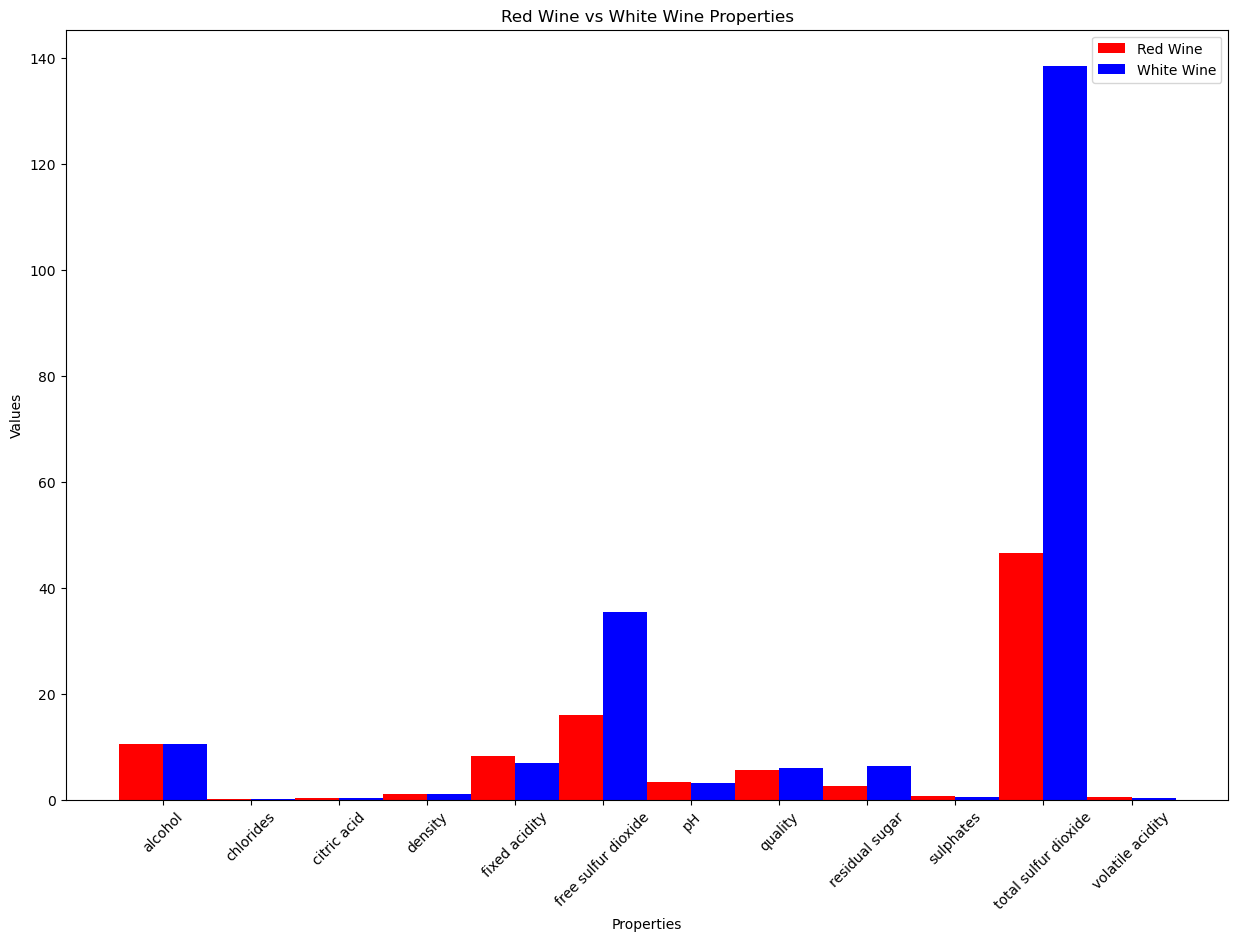

fixed acidity           0.124052
volatile acidity       -0.390558
citric acid             0.226373
residual sugar          0.013732
chlorides              -0.128907
free sulfur dioxide    -0.050656
total sulfur dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
quality                 1.000000
Name: quality, dtype: float64
fixed acidity          -0.113663
volatile acidity       -0.194723
citric acid            -0.009209
residual sugar         -0.097577
chlorides              -0.209934
free sulfur dioxide     0.008158
total sulfur dioxide   -0.174737
density                -0.307123
pH                      0.099427
sulphates               0.053678
alcohol                 0.435575
quality                 1.000000
Name: quality, dtype: float64
Red wine relevant features based on correlation with Quality:
alcohol    0.476166
Name: quality, dtype: float64
White wine relevant features based o

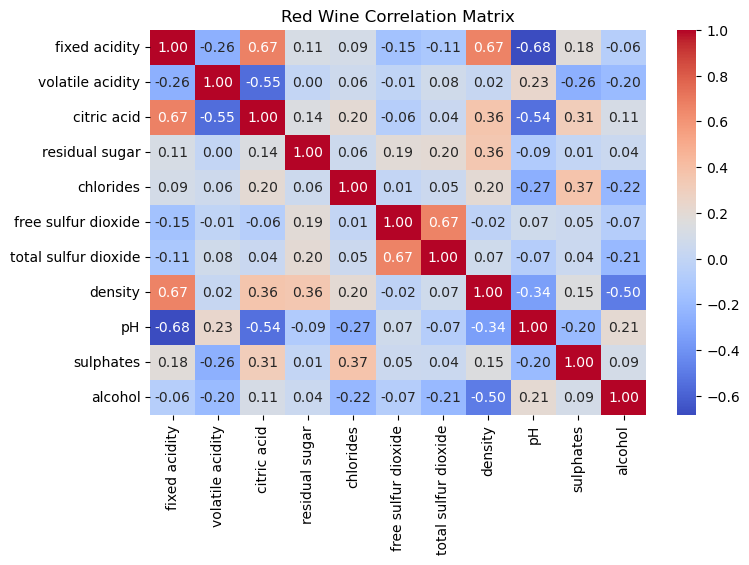

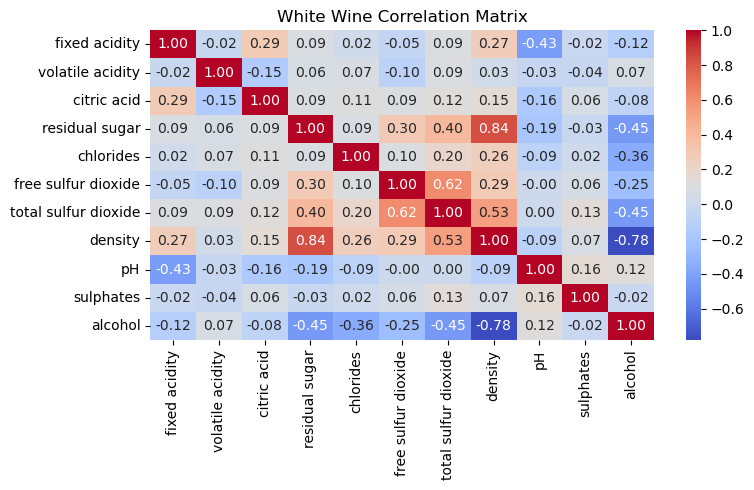

Red Wine Selected Features: ['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'pH' 'sulphates'
 'alcohol']
Red Wine Discarded Features: ['density']
WHite Wine Selected Features: ['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'pH' 'sulphates'
 'alcohol']
WHite Wine Discarded Features: ['density']


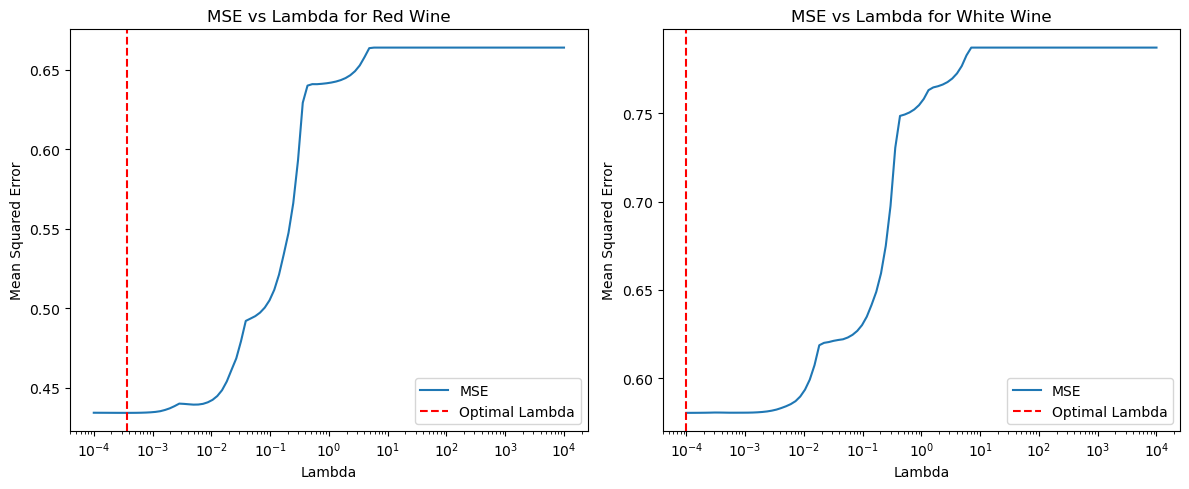

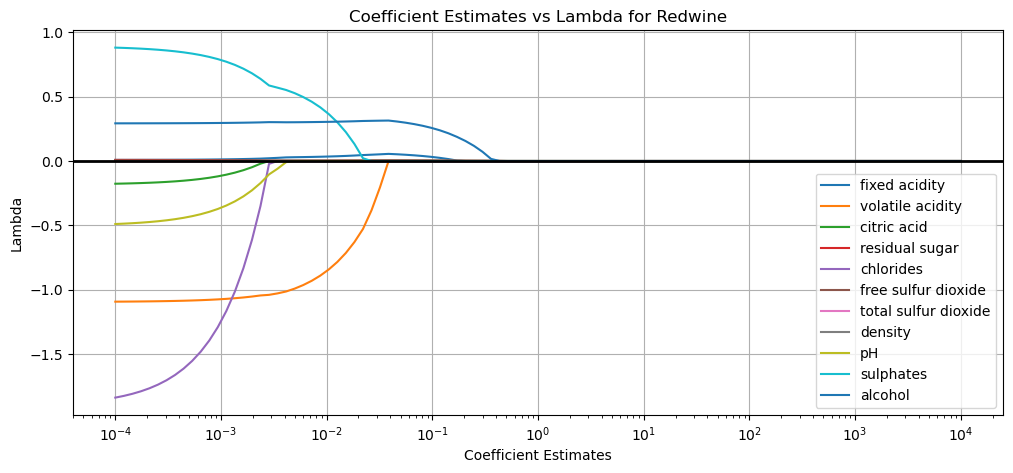

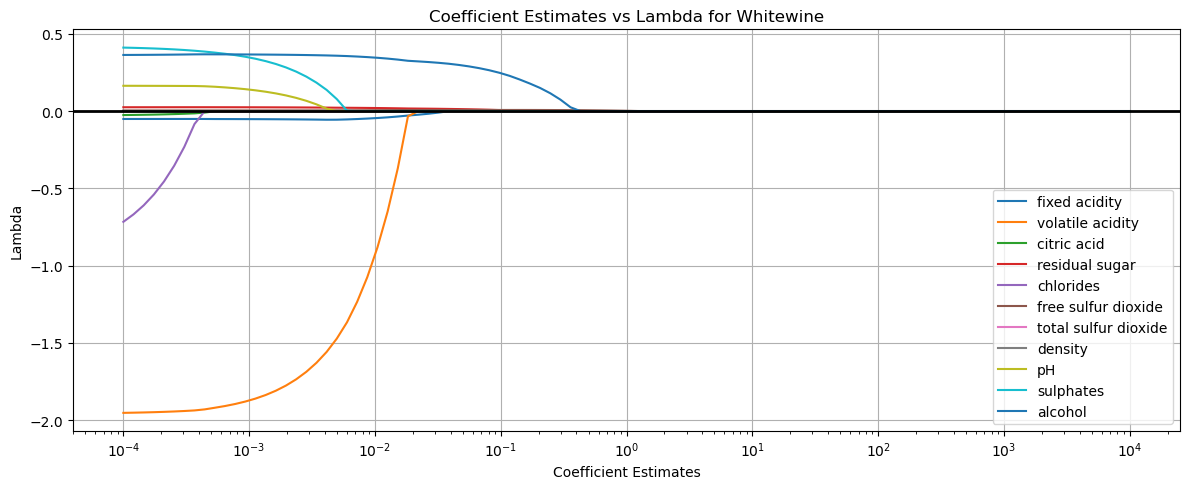

KNN Regression - Red Wine - Mean Squared Error: 0.84, R-squared: -0.29
Linear Regression - Red Wine - Mean Squared Error: 0.39, R-squared: 0.40


In [214]:
# to utilize the plot function 
import pandas as pd
# to plot and configure graphs
import matplotlib.pyplot as plt

import numpy as np

# to utilize the OLS
import statsmodels.api as st 

from sklearn.feature_selection import RFE

from sklearn.linear_model import LassoCV

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error as mse, r2_score

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, classification_report, precision_score, f1_score, recall_score

import seaborn as sb

# reading data from csv file
red_df = pd.read_csv('data/winequality-red.csv', delimiter=';')
white_df = pd.read_csv('data/winequality-white.csv', delimiter=';')

# print(titan_df)
# red_df['Source'] = 'Red'
# white_df['Source'] = 'White' 

# add_red = red_df.drop(columns='Sales')

agg_red = red_df.mean().reset_index()
agg_white = white_df.mean().reset_index()

agg_red.columns = ['Properties', 'Red_Values']
agg_white.columns = ['Properties', 'White_Values']

# print(agg_red)
# print(agg_white)

merged_df = pd.merge(agg_red, agg_white, on='Properties', how='outer').fillna(0)

wine_types = merged_df['Properties']
red_properties = merged_df['Red_Values']
white_properties = merged_df['White_Values']

bar_width = 0.5
x = np.arange(len(wine_types))

plt.figure(figsize=(15,10))
plt.bar(x-bar_width/2, red_properties, width=bar_width, label='Red Wine', color='red')
plt.bar(x+bar_width/2, white_properties, width=bar_width, label='White Wine', color='blue')

plt.xlabel('Properties')
plt.ylabel('Values')
plt.title('Red Wine vs White Wine Properties')
plt.xticks(x, wine_types, rotation=45)
plt.legend()

plt.show()

# drop the dependent variable before calculating correlation matrix
red_df_independent_vars = red_df.drop(columns=['quality'])
white_df_independent_vars = white_df.drop(columns=['quality'])

red_cr_matrix = red_df_independent_vars.corr()
white_cr_matrix = white_df_independent_vars.corr()

red_cr_target = red_df.corr()['quality']
print(red_cr_target)
white_cr_target = white_df.corr()['quality']
print(white_cr_target)

# setting lower threshold for strong correlation
threshold = 0.3

# excluding quality from the correlation matrix
red_relevant_features = red_cr_target[red_cr_target > threshold].drop('quality', errors='ignore')
print("Red wine relevant features based on correlation with Quality:")
print(red_relevant_features)
white_relevant_features = white_cr_target[white_cr_target > threshold].drop('quality', errors='ignore')
print("White wine relevant features based on correlation with Quality:")
print(white_relevant_features)

plt.figure(figsize=(8,5))
sb.heatmap(red_cr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Red Wine Correlation Matrix')

plt.figure(figsize=(8,5))
sb.heatmap(white_cr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('White Wine Correlation Matrix')
plt.tight_layout()
plt.show()



# performing lasso configuration with cross-validation

# red wine
y_red_wine = red_df['quality']
X_red_wine = red_df[['fixed acidity', 'volatile acidity', 'citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']]

# white wine
y_white_wine = white_df['quality']
X_white_wine = white_df[['fixed acidity', 'volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']]

# lasso regression for red wine with cross validation
lasso_red_wine = LassoCV(alphas=np.logspace(-4, 4, 100), cv=10)
lasso_red_wine.fit(X_red_wine, y_red_wine)

# lasso regression for white wine with cross validation
lasso_white_wine = LassoCV(alphas=np.logspace(-4, 4, 100), cv=10)
lasso_white_wine.fit(X_white_wine, y_white_wine)


# selected features for red wine
coefficients_red_wine = lasso_red_wine.coef_
selected_features_red_wine = np.array(X_red_wine.columns)[coefficients_red_wine != 0]
discarded_features_red_wine = np.array(X_red_wine.columns)[coefficients_red_wine == 0]

print("Red Wine Selected Features:", selected_features_red_wine)
print("Red Wine Discarded Features:", discarded_features_red_wine)

# selected features for white wine
coefficients_white_wine = lasso_white_wine.coef_
selected_features_white_wine = np.array(X_white_wine.columns)[coefficients_white_wine != 0]
discarded_features_white_wine = np.array(X_white_wine.columns)[coefficients_white_wine == 0]

print("WHite Wine Selected Features:", selected_features_white_wine)
print("WHite Wine Discarded Features:", discarded_features_white_wine)


# calculate mse for red wine
alphas_red_wine = lasso_red_wine.alphas_
mse_values_red_wine = lasso_red_wine.mse_path_.mean(axis=1)
    
# calculate mse for white wine
alphas_white_wine = lasso_white_wine.alphas_
mse_values_white_wine = lasso_white_wine.mse_path_.mean(axis=1)

# plot mse vs lambda
plt.figure(figsize=(12,5))

# redwine plot
plt.subplot(1,2,1)
plt.plot(alphas_red_wine, mse_values_red_wine, label='MSE')
# plt.plot(lasso_red_wine.alpha_, lasso_red_wine.mse_, 's', label='alpha:%f' % lasso_red_wine.alpha_)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Lambda for Red Wine')
plt.axvline(x=lasso_red_wine.alpha_, color='red', linestyle='--', label='Optimal Lambda')
plt.legend()

# whitewine plot
plt.subplot(1,2,2)
plt.plot(alphas_white_wine, mse_values_white_wine,label='MSE')
# plt.plot(lasso_white_wine.alpha_, lasso_white_wine.mse_, 's', label='alpha:%f' % lasso_white_wine.alpha_)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Lambda for White Wine')
plt.axvline(x=lasso_white_wine.alpha_, color='red', linestyle='--', label='Optimal Lambda')
plt.legend()

plt.tight_layout()
plt.show()




# coefficent paths for red wine
coefs_red_wine = []

for alpha in alphas_red_wine:
    lasso_temp = LassoCV(alphas=[alpha], cv=10)
    lasso_temp.fit(X_red_wine, y_red_wine)
    # y_pred_temp = lasso_temp.predict(X_red_wine)
    coefs_red_wine.append(lasso_temp.coef_)
    
coefs_red_wine = np.array(coefs_red_wine)

# coefficent paths for white wine
coefs_white_wine = []

for alpha in alphas_white_wine:
    lasso_temp = LassoCV(alphas=[alpha], cv=18)
    lasso_temp.fit(X_white_wine, y_white_wine)
    # y_pred_temp = lasso_temp.predict(X_white_wine)
    coefs_white_wine.append(lasso_temp.coef_)
    
coefs_white_wine = np.array(coefs_white_wine)
    

# plotting coefficients vs lambda for redwine
plt.figure(figsize=(12,5))

for i in range(coefs_red_wine.shape[1]):
    plt.plot(alphas_red_wine, coefs_red_wine[:, i], label=X_red_wine.columns[i])

plt.xscale('log')
plt.ylabel('Lambda')
plt.xlabel('Coefficient Estimates')
plt.title('Coefficient Estimates vs Lambda for Redwine')
plt.axhline(0, color='black', lw=2)
plt.legend(loc='lower right')
plt.grid()

# plotting coefficients vs lambda for whitewine
plt.figure(figsize=(12,5))

for i in range(coefs_white_wine.shape[1]):
    plt.plot(alphas_white_wine, coefs_white_wine[:,i], label=X_white_wine.columns[i])
    
plt.xscale('log')
plt.ylabel('Lambda')
plt.xlabel('Coefficient Estimates')
plt.title('Coefficient Estimates vs Lambda for Whitewine')
plt.axhline(0, color='black', lw=2)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# using selected features to construct KNN regression model for red wine
X_red_wine_selected = red_df[selected_features_red_wine]
y_a = red_df['quality']
X_train_red_wine, X_test_red_wine, y_train_red_wine, y_test_red_wine = train_test_split(X_red_wine_selected, y_red_wine, test_size=0.2, random_state=42)

knn_regressor_red_wine = KNeighborsClassifier(n_neighbors=5)
knn_regressor_red_wine.fit(X_train_red_wine, y_train_red_wine)

y_pred_red_wine = knn_regressor_red_wine.predict(X_test_red_wine)

mse_red_wine = mse(y_test_red_wine, y_pred_red_wine)
r2_red_wine = r2_score(y_test_red_wine, y_pred_red_wine)

print(f"KNN Regression - Red Wine - Mean Squared Error: {mse_red_wine:.2f}, R-squared: {r2_red_wine:.2f}")


# using selected features to construct KNN regression model for red wine

lin_reg_red_wine = LinearRegression()
lin_reg_red_wine.fit(X_train_red_wine, y_train_red_wine)

y_pred_red_wine = lin_reg_red_wine.predict(X_test_red_wine)

lr_mse_red_wine = mse(y_test_red_wine, y_pred_red_wine)
lr_r2_red_wine = r2_score(y_test_red_wine, y_pred_red_wine)

print(f"Linear Regression - Red Wine - Mean Squared Error: {lr_mse_red_wine:.2f}, R-squared: {lr_r2_red_wine:.2f}")



